In [362]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.optimize import fmin_powell
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn')

In [172]:
# simulate data

In [379]:
PRESIDENT_PROBABILITY = .03
ACCIDENT_PROBABILITY = .1
TRAFFIC_PROBABILITY = {(0, 0): .1, (0, 1): .5, (1, 0): .6, (1, 1): .9}
TRIALS = 200

In [382]:
president = np.random.binomial(n=1, p=PRESIDENT_PROBABILITY, size=TRIALS)
accident = np.random.binomial(n=1, p=ACCIDENT_PROBABILITY, size=TRIALS)

traffic_probabilities = [TRAFFIC_PROBABILIY[p, a] for p, a in zip(president, accident)]
traffic = np.random.binomial(n=1, p=traffic_probabilities)

In [385]:
print( f'President Mean: {president.mean()}' )
print( f'Accident Mean: {accident.mean()}' )
print( f'Traffic Mean: {traffic.mean()}')

President Mean: 0.04
Accident Mean: 0.1
Traffic Mean: 0.145


In [386]:
observed_data = pd.DataFrame({'president': president, 'accident': accident, 'traffic': traffic})

In [387]:
# probabilities are no longer fixed values, but distributions

In [388]:
times_president_observed = sum(president)
times_president_not_observed = len(president) - times_president_observed

president_probability_samples = np.random.beta(
    a=1 + times_president_observed, 
    b=1 + times_president_not_observed, 
    size=4567
)

In [389]:
times_accident_observed = sum(accident)
times_accident_not_observed = len(accident) - times_accident_observed

accident_probability_samples = np.random.beta(
    a=1 + times_accident_observed, 
    b=1 + times_accident_not_observed, 
    size=4567
)

In [390]:
# P(traffic | accident, president)

In [391]:
# logistic regression baseline

glm = LogisticRegression()
_ = glm.fit(X=observed_data[['president', 'accident']], y=observed_data['traffic'])

In [392]:
precision = 5
print( f'Estimated intercept: {glm.intercept_[0]:.{precision}}' )
print( f'Estimated president coefficient: {glm.coef_[0][0]:.{precision}}' )
print( f'Estimated accident coefficient: {glm.coef_[0][1]:.{precision}}' )

Estimated intercept: -1.9553
Estimated president coefficient: 0.91366
Estimated accident coefficient: 1.4543


In [393]:
with pm.Model() as model:
    pm.glm.glm('traffic ~ president + accident', observed_data, family=pm.glm.families.Binomial())
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
    step = pm.NUTS(scaling=start_MAP)
    trace = pm.sample(2000, step=step, njobs=2, progressbar=True)

100%|██████████| 2000/2000 [00:06<00:00, 316.27it/s]


In [394]:
# i'm not sure why, but everything seems to go to hell when i have `njobs=4`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1691d6860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x169aea898>]], dtype=object)

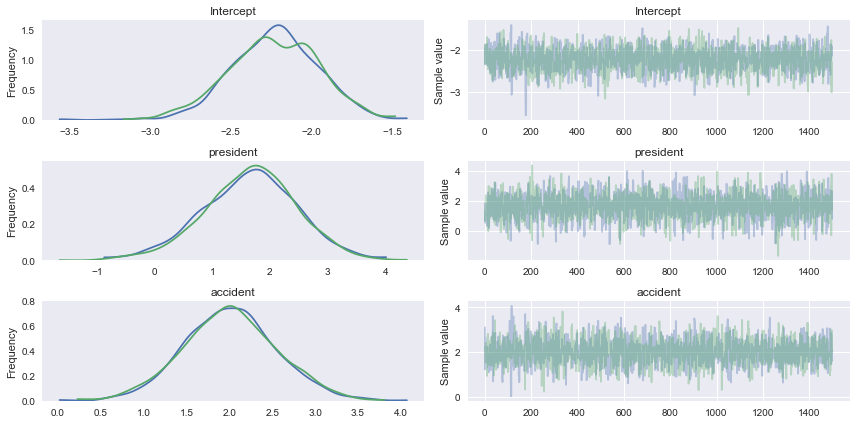

In [395]:
warmup = 500
variables = ['Intercept', 'president', 'accident']

pm.traceplot(trace[warmup:], varnames=variables)

In [396]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_counterfactual_predictions(president_value, accident_value, trace=trace):
    log_odds_p = trace['Intercept'] + trace['president']*president_value + trace['accident']*accident_value
    return sigmoid(log_odds_p)

In [401]:
input_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
counterfactual_predictions = {}
observed_proportions = {}

for p, a in input_combinations:
    counterfactual_predictions[(p, a)] = compute_counterfactual_predictions(p, a)
    observed_proportions[(p, a)] = observed_data[(observed_data['president'] == p) & (observed_data['accident'] == a)]['traffic'].mean()

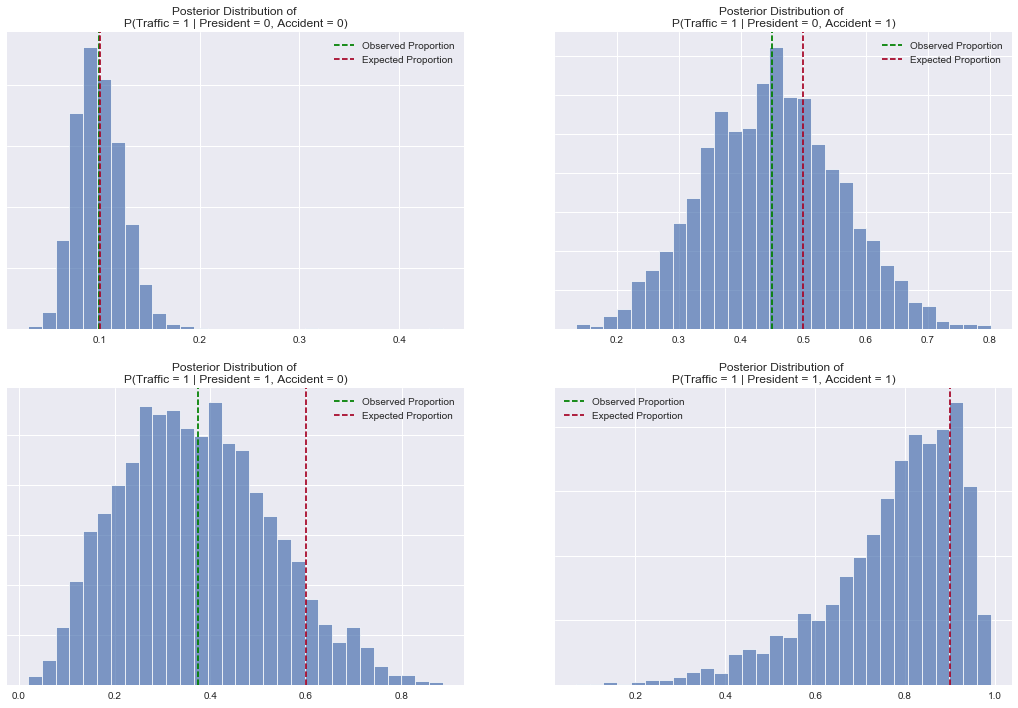

In [403]:
plt.figure(figsize=(18, 12))

for subplot_idx, (p, a) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    predictions = counterfactual_predictions[(p, a)]
    observed_proportion = observed_proportions[(p, a)]
    expected_proportion = TRAFFIC_PROBABILITY[(p, a)]
    
    subplot = plt.subplot(221 + subplot_idx)
    plt.setp(subplot.get_yticklabels(), visible=False)
    plt.hist(predictions, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(observed_proportion, color='green', linestyle='--', label = 'Observed Proportion')
    plt.axvline(expected_proportion, color='#A60628', linestyle='--', label = 'Expected Proportion')
    title = 'Posterior Distribution of \nP(Traffic = 1 | President = {}, Accident = {})'.format(p, a)
    plt.title(title)
    plt.legend()